# Noise Estimation and Adaptive Encoding for Asymmetric Quantum Error Correcting Codes
_Jan Florjanczyk, Supervisor: Todd A. Brun_



In [123]:
% matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from matplotlib import cm
from glob import glob
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
sns.set_style("whitegrid")
from drift_qec.oneangledephasing import *

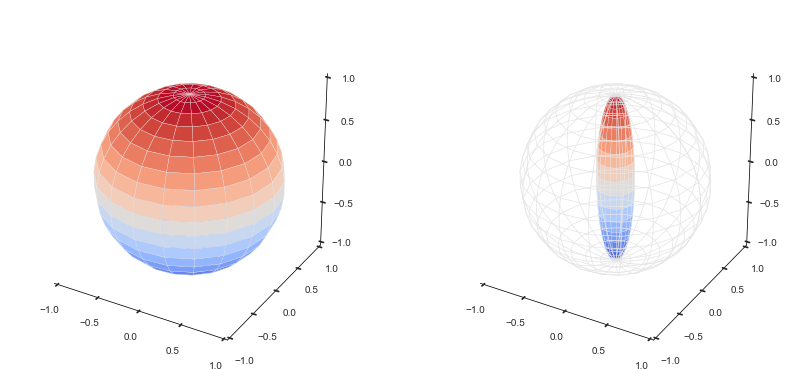

In [3]:
fig = plt.figure(figsize=(14,10))
axs = ["", ""]
axs[0] = fig.add_subplot(121, projection='3d')
axs[1] = fig.add_subplot(122, projection='3d')

axs[0].set_aspect("equal")
axs[0].set_frame_on(False)
axs[0].w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[0].w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[0].w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[0].grid(False)

axs[1].set_aspect("equal")
axs[1].set_frame_on(False)
axs[1].w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[1].w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[1].w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[1].grid(False)

u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:20j]
x=np.cos(u)*np.sin(v)
y=np.sin(u)*np.sin(v)
z=np.cos(v)
axs[0].plot_surface(x, y, z, rstride=1, cstride=1, cmap=cm.coolwarm)
axs[1].plot_wireframe(x, y, z, color=[0.9, 0.9, 0.9], linewidth=0.75)
x=0.2*np.cos(u)*np.sin(v)
y=0.2*np.sin(u)*np.sin(v)
z=1.0*np.cos(v)
axs[1].plot_surface(x, y, z, rstride=1, cstride=1, cmap=cm.coolwarm)

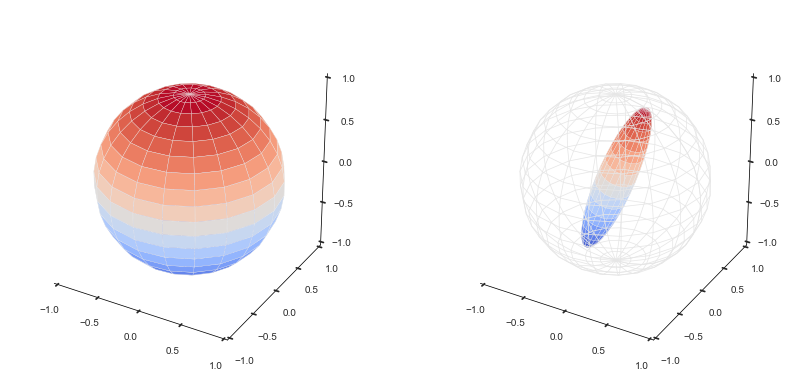

In [4]:
fig = plt.figure(figsize=(14,10))
axs = ["", ""]
axs[0] = fig.add_subplot(121, projection='3d')
axs[1] = fig.add_subplot(122, projection='3d')

axs[0].set_aspect("equal")
axs[0].set_frame_on(False)
axs[0].w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[0].w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[0].w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[0].grid(False)

axs[1].set_aspect("equal")
axs[1].set_frame_on(False)
axs[1].w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[1].w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[1].w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[1].grid(False)

u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:20j]
x=np.cos(u)*np.sin(v)
y=np.sin(u)*np.sin(v)
z=np.cos(v)
axs[0].plot_surface(x, y, z, rstride=1, cstride=1, cmap=cm.coolwarm)
axs[1].plot_wireframe(x, y, z, color=[0.9, 0.9, 0.9], linewidth=0.75)
x0=0.2*np.cos(u)*np.sin(v)
y0=0.2*np.sin(u)*np.sin(v)
z0=1.0*np.cos(v)
x = x0*np.sin(-1.2) + z0*np.cos(-1.2)
y = y0
z = x0*np.cos(-1.2) - z0*np.sin(-1.2)
axs[1].plot_surface(x, y, z, rstride=1, cstride=1, cmap=cm.coolwarm)

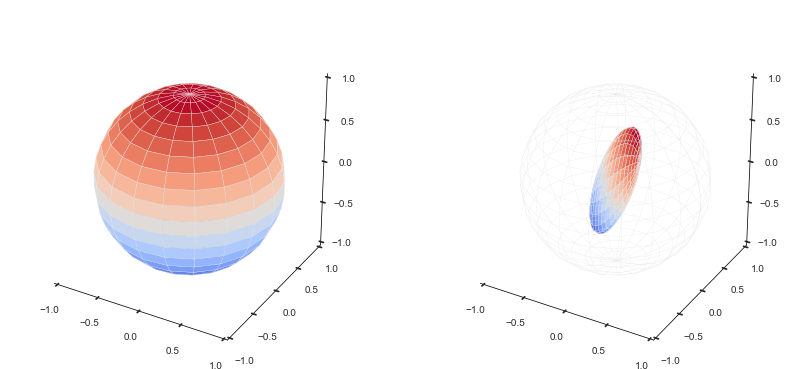

In [122]:
fig = plt.figure(figsize=(14,10))
axs = ["", ""]
axs[0] = fig.add_subplot(121, projection='3d')
axs[1] = fig.add_subplot(122, projection='3d')

axs[0].set_aspect("equal")
axs[0].set_frame_on(False)
axs[0].w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[0].w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[0].w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[0].grid(False)

axs[1].set_aspect("equal")
axs[1].set_frame_on(False)
axs[1].w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[1].w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[1].w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[1].grid(False)

u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:20j]
x=np.cos(u)*np.sin(v)
y=np.sin(u)*np.sin(v)
z=np.cos(v)
axs[0].plot_surface(x, y, z, rstride=1, cstride=1, cmap=cm.coolwarm)
axs[1].plot_wireframe(x, y, z, color=[0.9, 0.9, 0.9], linewidth=0.25)
k, p = 0.5, 0.6
px, py, pz = p, 0, k*p
x0=(1.0 - py - pz)*np.cos(u)*np.sin(v)
y0=(1.0 - px - pz)*np.sin(u)*np.sin(v)
z0=(1.0 - px - py)*np.cos(v)
x1 = x0*np.sin(0.5) + y0*np.cos(0.5)
y1 = x0*np.cos(0.5) - y0*np.sin(0.5)
z1 = z0
x = x1*np.sin(-0.8) + z1*np.cos(-0.8)
y = y1
z = x1*np.cos(-0.8) - z1*np.sin(-0.8)
axs[1].plot_surface(x, y, z, rstride=1, cstride=1, cmap=cm.coolwarm)

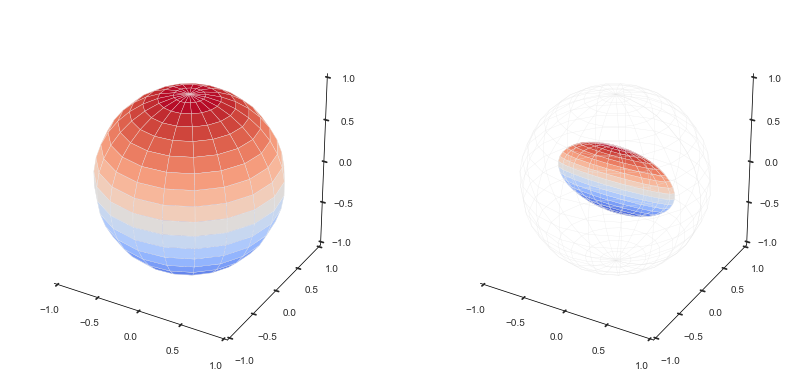

In [120]:
fig = plt.figure(figsize=(14,10))
axs = ["", ""]
axs[0] = fig.add_subplot(121, projection='3d')
axs[1] = fig.add_subplot(122, projection='3d')

axs[0].set_aspect("equal")
axs[0].set_frame_on(False)
axs[0].w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[0].w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[0].w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[0].grid(False)

axs[1].set_aspect("equal")
axs[1].set_frame_on(False)
axs[1].w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[1].w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[1].w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[1].grid(False)

u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:20j]
x=np.cos(u)*np.sin(v)
y=np.sin(u)*np.sin(v)
z=np.cos(v)
axs[0].plot_surface(x, y, z, rstride=1, cstride=1, cmap=cm.coolwarm)
axs[1].plot_wireframe(x, y, z, color=[0.9, 0.9, 0.9], linewidth=0.25)
k, p = 0.5, 0.6
px, py, pz = p, 0, k*p
x=(1.0 - py - pz)*np.cos(u)*np.sin(v)
y=(1.0 - px - pz)*np.sin(u)*np.sin(v)
z=(1.0 - px - py)*np.cos(v)
axs[1].plot_surface(x, y, z, rstride=1, cstride=1, cmap=cm.coolwarm)

## Fixed angle dephasing channel

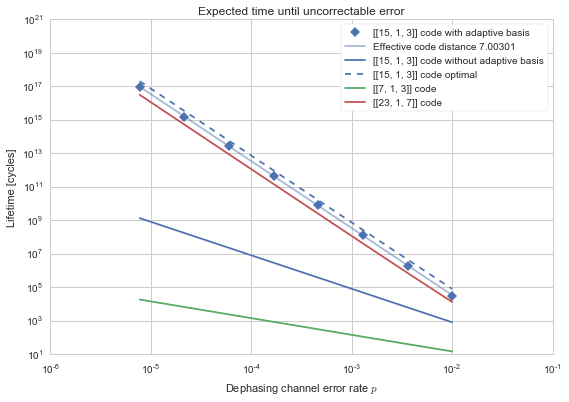

In [108]:
def uncorr_rates(N, t, ps):
    puncorrs = np.zeros(ps.shape)
    for idx, p in enumerate(ps):
        puncorr = 0.0
        for k in np.arange(t, N):
            puncorr = puncorr + sp.misc.comb(N, k) * ((1-p) ** (N-k)) * (p ** k)
        puncorrs[idx] = puncorr
    return puncorrs

df = pd.read_csv("data/OneAngleDephasingFixed/src.csv", index_col=0)
df = df.loc[df["time"] < df["max_t"], :]

ps = times.index.values
opt = pd.DataFrame({"rate": ps, "max_opt_t": 1.0 / uncorr_rates(15, 4, ps)})
df = pd.merge(df, opt, how="left")

# df = df.loc[df["time"] < df["max_opt_t"], :]
df = df.loc[df["time"] < 1.0 / df["p_uncorrectable"], :]


times = df[["rate", "time"]].groupby(["rate"]).aggregate([np.mean, sp.stats.sem])
times.columns=["mean", "sem"]

x = np.log(times["mean"].index)
y = np.log(times["mean"].values)
ps = times.index.values
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(x,y)
f = np.exp(intercept + x * slope)

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.loglog(times.index, times["mean"], marker="D", ls="",
          color=sns.color_palette()[0], label="[[15, 1, 3]] code with adaptive basis")
# ax.loglog(times.index, times["mean"] - times["sem"], ls="--", color=sns.color_palette()[0])
# ax.loglog(times.index, times["mean"] + times["sem"], ls="--", color=sns.color_palette()[0])

ax.loglog(times.index, f, color=sns.color_palette()[0], ls="-",
          label="Effective code distance {:1.5f}".format(-2*slope-1), alpha=0.5)

ax.loglog(times.index, 16.0/(63.0 * 3.141592 * (times.index.values ** 2)),
          color=sns.color_palette()[0], label="[[15, 1, 3]] code without adaptive basis")

ax.loglog(times.index, 1.0/(uncorr_rates(15, 4, ps)),
          color=sns.color_palette()[0], label="[[15, 1, 3]] code optimal", ls="--")

ax.loglog(times.index, 1.0/(uncorr_rates(7, 1, ps)),
          color=sns.color_palette()[1], label="[[7, 1, 3]] code")

ax.loglog(times.index, 1.0/(uncorr_rates(23, 4, ps)),
          color=sns.color_palette()[2], label="[[23, 1, 7]] code")
ax.axis([1e-6, 1e-1, 1e1, 1e21])
ax.set_title("Expected time until uncorrectable error")
ax.set_xlabel("Dephasing channel error rate $p$")
ax.set_ylabel("Lifetime [cycles]")
ax.legend(frameon=True)
fig.savefig("figures/fixedangledephasinglifetimes.pdf")

## Drifting angle dephasing channel

In [7]:
max_time = 1000
params = {"Theta": Theta(max_time, grains=10000, sigma=0.03)}
constants = {"p": Constant(0.003, "p")}

estimator = OneAngleDephasingEstimator(params, constants)
channel = OneAngleDephasingChannel(15, max_time)
report = Report("One Angle Dephasing")

time = 0
while time < max_time:
    s = channel.error(estimator.params, estimator.constants, time)
    estimator.update(s, time)
    report.record(s, time)
    time = time + 1
report.exit(time, "oot", estimator)

fig, ax = plt.subplots(figsize=(7, 5))
report.plot(ax, weightson=True)
ax.legend(frameon=True, loc=4)
ax.set_title("Dephasing angle Theta and estimate")
ax.set_ylabel("Angle (radians)")
ax.set_xlabel("Error correction cycle")
fig.savefig("figures/driftingangledephasingrun.pdf")

TypeError: __init__() got multiple values for keyword argument 'grains'

In [8]:
df = pd.concat([pd.read_csv(path) for path in glob("data/OneAngleDephasingDriftMore/*.csv")])

In [9]:
s = df.groupby("error_rate").aggregate([np.mean, sp.stats.sem]).reset_index()

In [10]:
s

error_rate   sigma                      exit_time                
                mean           sem             mean             sem
0     0.0001  0.0001  4.633361e-21  43045661.512821  3274780.568315
1     0.0002  0.0002  0.000000e+00  13850855.085427   804141.174937
2     0.0005  0.0005  7.685705e-21   2477043.475000   109805.635059
3     0.0010  0.0010  1.537141e-20    633518.130000    32993.788378
4     0.0020  0.0020  3.074282e-20    160232.265000     8643.376988
5     0.0050  0.0050  6.148564e-20     26860.930000     1410.775152
6     0.0100  0.0100  1.229713e-19      5984.505000      369.190742

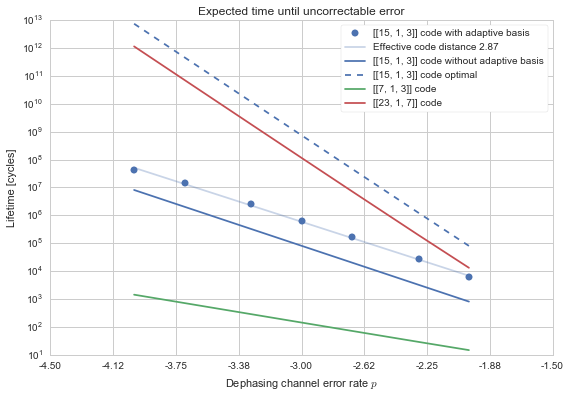

In [109]:
x = np.log(s[("error_rate", )])
y = np.log(s[("exit_time", "mean")])
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(x,y)

ps = s[("error_rate", )].values

xmin = -4.5
xmax = -1.5
xn = 9
f = np.exp(intercept) * (np.logspace(-4, -2, xn) ** slope)

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plt.loglog(s[("error_rate", )], s[("exit_time", "mean")], ls="", marker="o",
           color=sns.color_palette()[0], label="[[15, 1, 3]] code with adaptive basis")
# plt.loglog(s[("error_rate", )], s[("exit_time", "mean")] - s[("exit_time", "sem")],
#            ls="--", color=sns.color_palette()[0])
# plt.loglog(s[("error_rate", )], s[("exit_time", "mean")] + s[("exit_time", "sem")],
#            ls="--", color=sns.color_palette()[0])
ax.loglog(np.logspace(-4, -2, xn), f, color=sns.color_palette()[0], ls="-",
          label="Effective code distance {:1.2f}".format(-2*slope-1), alpha=0.3)

ax.loglog(s[("error_rate", )], 16.0/(63.0 * 3.141592 * (s[("error_rate", )].values ** 2)),
          color=sns.color_palette()[0], label="[[15, 1, 3]] code without adaptive basis")

ax.loglog(s[("error_rate", )], 1.0/(uncorr_rates(15, 4, ps)),
          color=sns.color_palette()[0], label="[[15, 1, 3]] code optimal", ls="--")

ax.loglog(s[("error_rate", )], 1.0/(uncorr_rates(7, 1, ps)),
          color=sns.color_palette()[1], label="[[7, 1, 3]] code")

ax.loglog(s[("error_rate", )], 1.0/(uncorr_rates(23, 4, ps)),
          color=sns.color_palette()[2], label="[[23, 1, 7]] code")
labels = ["{:1.2f}".format(x) for x in np.linspace(xmin, xmax, xn)]
plt.xticks(np.logspace(xmin, xmax, xn), labels)
plt.axis([(10 ** xmin), (10 ** xmax), 1e1, 1e13])
plt.legend(frameon=True)
plt.title("Expected time until uncorrectable error")
plt.xlabel("Dephasing channel error rate $p$")
plt.ylabel("Lifetime [cycles]")

## Drift rate

In [142]:
from glob import glob
files = glob("data/Archive/*.csv")
dfs = [pd.read_csv(fname) for fname in files]
df = pd.concat(dfs)

df.columns = ["error_rate", "drift_rate", "exit_time", "exit_status"]
error_rates = np.unique(df["error_rate"])
t = df.pivot_table(index="drift_rate", columns="error_rate", values="exit_time")
s = df.pivot_table(index="drift_rate", columns="error_rate", values="exit_time", aggfunc=lambda x: sp.stats.sem(x))

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

for idx, error_rate in enumerate(error_rates):
    x = t.loc[:, error_rate].index
    y = t.loc[:, error_rate].values
    e = s.loc[:, error_rate].values
    ax.loglog(x, y, marker="D", ls="",
              color=sns.color_palette()[idx], label="error rate {:1.3f}".format(error_rate))
    ax.loglog(x, y+e, ls="--", color=sns.color_palette()[idx])
    ax.loglog(x, y-e, ls="--", color=sns.color_palette()[idx])
    ax.axhline(1.0 / uncorr_rates(15, 2, np.array([error_rate])), color=sns.color_palette()[idx], ls="-")
    
ax.set_title("Expected time until uncorrectable error")
ax.set_xlabel("Drift rate (random walk step size)")
ax.set_ylabel("Lifetime [cycles]")
ax.legend(frameon=True)

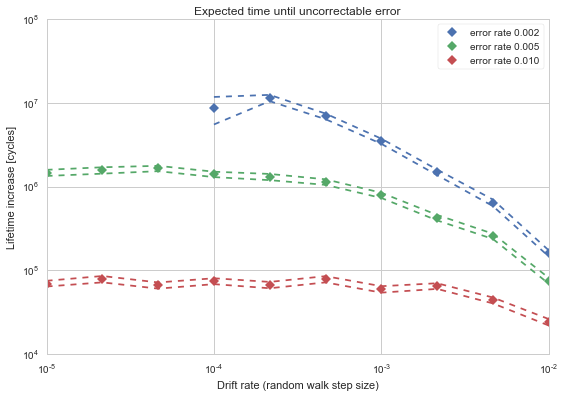

In [162]:
from glob import glob
files = glob("data/Archive/*.csv")
dfs = [pd.read_csv(fname) for fname in files]
df = pd.concat(dfs)

df.columns = ["error_rate", "drift_rate", "exit_time", "exit_status"]
error_rates = np.unique(df["error_rate"])
t = df.pivot_table(index="drift_rate", columns="error_rate", values="exit_time")
s = df.pivot_table(index="drift_rate", columns="error_rate", values="exit_time", aggfunc=lambda x: sp.stats.sem(x))

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

for idx, error_rate in enumerate(error_rates):
    baseline = 1.0 / uncorr_rates(15, 2, np.array([error_rate]))[0]
    x = t.loc[:, error_rate].index
    y = t.loc[:, error_rate].values - baseline
    e = s.loc[:, error_rate].values
    ax.loglog(x, y, marker="D", ls="",
              color=sns.color_palette()[idx], label="error rate {:1.3f}".format(error_rate))
    ax.loglog(x, y+e, ls="--", color=sns.color_palette()[idx])
    ax.loglog(x, y-e, ls="--", color=sns.color_palette()[idx])
    
ax.set_title("Expected time until uncorrectable error")
ax.set_xlabel("Drift rate (random walk step size)")
ax.set_ylabel("Lifetime increase [cycles]")
ax.legend(frameon=True)